<a href="https://colab.research.google.com/github/rkh97/ML-foundations/blob/master/rope2_Try2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 데이터 분석을 위한 라이브러리
import pandas as pd
import numpy as np
import sklearn

# 시각화 라이브러리
import matplotlib
import matplotlib.pyplot as plt

# mglearn 다운
!wget -q -O mglearn.tar.gz https://bit.ly/mglearn-tar-gz
!tar -xzf mglearn.tar.gz
!wget -q -O data.tar.gz https://bit.ly/data-tar-gz
!tar -xzf data.tar.gz

# 나눔 폰트 설치
!sudo apt-get -qq -y install fonts-nanum
import matplotlib.font_manager as fm
font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
for fpath in font_files:
  fm.fontManager.addfont(fpath)

# 데이터 열기
from google.colab import drive
drive.mount('/content/drive')

rope1 = pd.read_excel('/content/drive/MyDrive/rope-노경희/1단 500개_중간에 두번 걸림.xlsx', header=None)
rope2 = pd.read_excel('/content/drive/MyDrive/rope-노경희/2단뛰기 데이터.xlsx', header=None)
real = pd.read_excel('/content/drive/MyDrive/rope-노경희/1단 4개 2단 50개 데이터.xlsx', header=None)

debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120879 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
Mounted at /content/drive


# 1- Preprocessing

In [ ]:
# 전처리 함수 생성
def preprocessing (data):

  # 2행과 3행 제거 (touched sensor number 데이터와 ticks 데이터만 이용)
  if len(data) > 3:
      data = data.drop([2, 3])
  else:
      data = data.drop([2])

  # 모든 셀의 값을 정수로 변환
  new_data = data.applymap(lambda x: int(x))

  # 첫 번째 행에서 4, 3, 2, 1이 연달아 나타나는 경우 추출 (넘어지거나, 가만히 있는 경우 제거)
  start_indices = []
  for i in range(len(new_data.columns) - 3):
      if list(new_data.loc[0, i:i+3]) == [4, 3, 2, 1]:
        if list(new_data.loc[0, i + 4:i + 8]) == [4, 4, 3, 2, 1]: # 4, 4, 3, 2, 1 인 경우(노란색부분) 제외하고 추출
          continue
        start_indices.append(i)

  # 데이터프레임을 분할하여 각각의 데이터프레임 생성
  dfs = []
  for i in range(len(start_indices)):
      sub_df = new_data.iloc[:, start_indices[i]:start_indices[i] + 4]
      dfs.append(sub_df)

  return dfs

In [ ]:
# rope1 데이터로부터 전처리된 데이터프레임 생성
preprocessed_rope1 = preprocessing(rope1)

# # 결과 출력
# for i, df in enumerate(preprocessed_rope1, start=1):
#     df_name = f"df1_{i}"
#     globals()[df_name] = df
#     print(f"{df_name}:\n{df}\n")

# rope2 데이터로부터 전처리된 데이터프레임 생성
preprocessed_rope2 = preprocessing(rope2)

# # 결과 출력
# for i, df in enumerate(preprocessed_rope2, start=1):
#     df_name = f"df2_{i}"
#     globals()[df_name] = df
#     print(f"{df_name}:\n{df}\n")

# real 데이터로부터 전처리된 데이터프레임 생성
preprocessed_real = preprocessing(real)

# # 결과 출력
# for i, df in enumerate(preprocessed_real, start=1):
#     df_name = f"real_{i}"
#     globals()[df_name] = df
#     print(f"{df_name}:\n{df}\n")


In [ ]:
# 데이터 프레임 생성
X = []
y = []

for rope1 in preprocessed_rope1:
    X.append(rope1.iloc[1, :].values)  # 2번째 행 데이터를 피처로 사용
    y.append(0)  # 1단 줄넘기

for rope2 in preprocessed_rope2:
    X.append(rope2.iloc[1, :].values)  # 2번째 행 데이터를 피처로 사용
    y.append(1)  # 2단 줄넘기

X = np.array(X)
y = np.array(y)

# 2- Feature engineering

- 피처 스케일링을 하기 전, rope 데이터의 분포를 살펴보겠습니다.

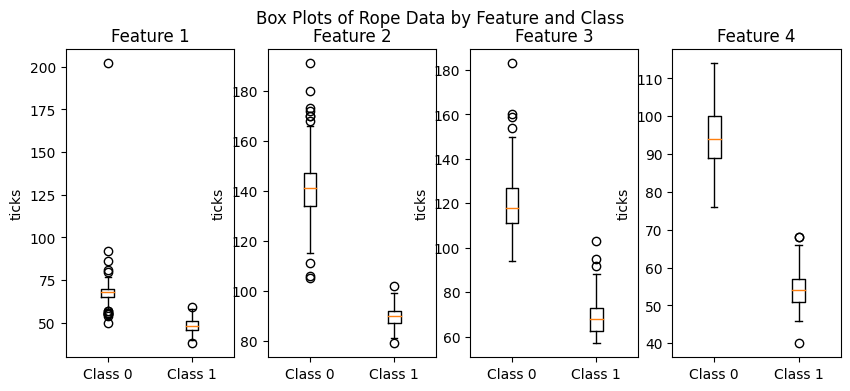

In [ ]:
# 클래스 0에 해당하는 데이터
X_class0 = X[y == 0]
y_class0 = y[y == 0]

# 클래스 1에 해당하는 데이터
X_class1 = X[y == 1]
y_class1 = y[y == 1]

# 박스 플롯 그리기
fig, axes = plt.subplots(1, 4, figsize=(10, 4))
for i in range(4):  # 피처의 개수만큼 반복
    axes[i].boxplot([X_class0[:, i], X_class1[:, i]], labels=['Class 0', 'Class 1'])
    axes[i].set_ylabel('ticks')
    axes[i].set_title(f'Feature {i + 1}')

plt.suptitle('Box Plots of Rope Data by Feature and Class')
plt.show()

- 데이터의 분포를 확인해보니 정규분포를 따르지 않고 다수의 이상치가 존재하기 때문에 이상치에 민감한 Standard Scaler를 사용하는 것은 적절하지 않아보입니다.
- 따라서 0과 1사이로 정해진 범위 내로 스케일링을 해주며 데이터의 상대적 크기를 보존해주는 MinMax Scaler를 사용하도록 하겠습니다.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# 피처 스케일링
scaler = MinMaxScaler()
X_minmax = scaler.fit_transform(X)

- 과적합을 막기 위해 차원축소를 하여 모델을 보다 단순하게 만들도록 하겠습니다.
- 차원 축소를 하기 전, 먼저 히트맵을 통해 피처들 간의 상관관계를 살펴보겠습니다.

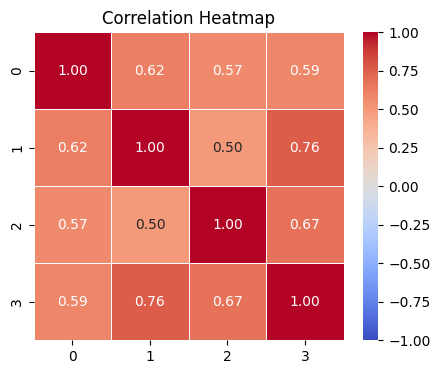

In [ ]:
import seaborn as sns

X_df = pd.DataFrame(X)

# 상관 행렬 계산
correlation_matrix = X_df.corr()

# 상관 히트맵 시각화
plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, norm=plt.Normalize(vmin=-1, vmax=1))
plt.title("Correlation Heatmap")
plt.show()

- 히트맵을 확인한 결과 피처들 간의 상관계수가 높게 나왔습니다.
- 상관계수가 높은 피처들을 모델에 포함하면, 각 피처들 간의 상호 의존성으로 인해 모델이 불안정해지고 일부 피처가 중복 정보를 제공할  수 있으므로 다중공선성에 강건한 의사결정트리 모델로 중요한 피처를 추출해 사용하도록 하겠습니다.
- 또한, 이는 모델의 복잡성을 줄여 계산비용과 모델의 학습시간의 감소시키기 위함이기도 합니다.



In [ ]:
from sklearn.tree import DecisionTreeClassifier

# 결정 트리 모델 학습
tree_model = DecisionTreeClassifier()
tree_model.fit(X_minmax, y)

# 중요한 피처 추출
feature_importance = tree_model.feature_importances_

# 중요도가 높은 상위 두 개의 피처 선택
top_features_indices = feature_importance.argsort()[-2:][::-1]
selected_features = X_minmax[:, top_features_indices]

top_features_indices

array([3, 2])

In [ ]:
from sklearn.model_selection import train_test_split

# 데이터를 훈련 세트(train set), 테스트 세트(test set)로 분할
X_train, X_test, y_train, y_test = train_test_split(selected_features, y, test_size=0.2, random_state=42)

# 3- Model training using SVM

- SVM 모델을 사용한 이유는 다음과 같습니다.

  - rope데이터는 특정 패턴을 가진 두 클래스의 데이터이므로 선형분리를 잘하는 svm모델을 사용하면 좋은 결과를 얻을 것이라 생각했습니다.
  - 이상치가 있는 이러한 데이터 특성상 이상치에 민감하지 않은 svm모델이 유리하다고 판단하였습니다.
  - svm모델은 마진을 최대화하며 분류 경계 주변의 데이터 포인트에 집중하기 때문에 일반화 성능이 높을 수 있습니다.

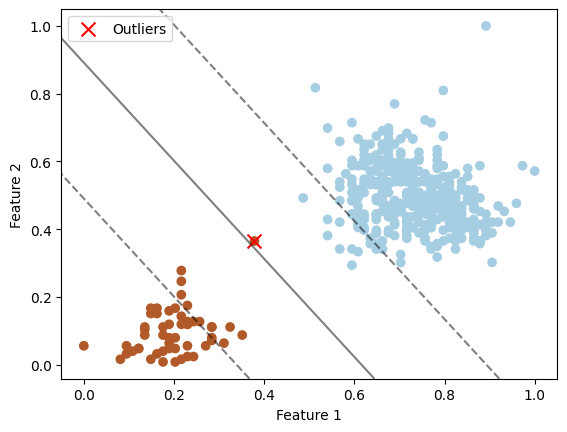

Outlier indices: [162]
Outlier classes: [1]


In [ ]:
from sklearn import svm

# SVM 분류기 생성
svm = svm.SVC(kernel='linear', C=1, probability=True, random_state=42)

# SVM 모델 학습
svm.fit(X_train, y_train)

# 두 개의 피처를 x와 y 좌표로 추출
x_values = [point[0] for point in X_train]
y_values = [point[1] for point in X_train]

# 결정 경계 그리기
plt.scatter(x_values, y_values, c=y_train, cmap=plt.cm.Paired)
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# 결정 경계 생성
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 50),
                     np.linspace(ylim[0], ylim[1], 50))
Z = svm.decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# 결정 경계와 마진 시각화
plt.contour(xx, yy, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
            linestyles=['--', '-', '--'])

# 이상치 식별을 위해 SVM에서 분류한 결과를 표시
predicted_labels = svm.predict(X_train)
outlier_indices = np.where(predicted_labels != y_train)[0]  # 인덱스 추출

# 이상치의 클래스 확인
outlier_classes = [y_train[index] for index in outlier_indices]

plt.scatter(np.array(x_values)[outlier_indices], np.array(y_values)[outlier_indices],
            marker='x', s=100, c='red', label='Outliers')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend(loc='best')
plt.show()

print(f'Outlier indices: {outlier_indices}')
print(f'Outlier classes: {outlier_classes}')

- 이상치에 민감하지 않는 svm모델이지만, 결정 경계를 벗어난 이상치 하나가 존재합니다.
- 우선, 이 상태로 성능 평가를 해보겠습니다.

#4- Evaluation with test data

In [ ]:
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, auc,  precision_recall_curve, average_precision_score
from sklearn.metrics._plot.confusion_matrix import confusion_matrix
import seaborn as sns

# 평가 지표 함수 생성
def get_clf_eval(y_test, pred = None, probability = True):
  accuracy = accuracy_score(y_test, pred)
  precision = precision_score(y_test, pred)
  recall = recall = recall_score(y_test, pred)
  f1 = f1_score(y_test, pred)
  roc_auc = roc_auc_score(y_test, pred)

  # 정확도, 정밀도, 재현률, F1 출력
  print(f'정확도 : {accuracy:.4f}, 정밀도 : {precision:.4f}, 재현율 : {recall:.4f}, F1 : {f1:.4f}')

  # confusion matrix 출력
  cm = confusion_matrix(y_test, pred)

  plt.figure(figsize=(4,3))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', annot_kws={'size': 8})
  plt.xlabel('predicted')
  plt.ylabel('actual')
  plt.title('Confusion Matrix')
  plt.show()


정확도 : 1.0000, 정밀도 : 1.0000, 재현율 : 1.0000, F1 : 1.0000


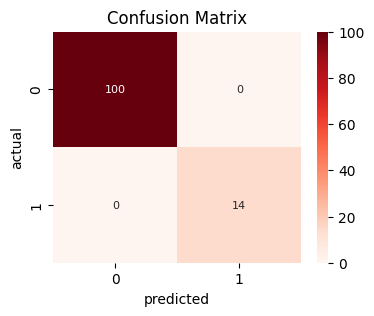

In [ ]:
pred = svm.predict(X_test)
get_clf_eval(y_test, pred)

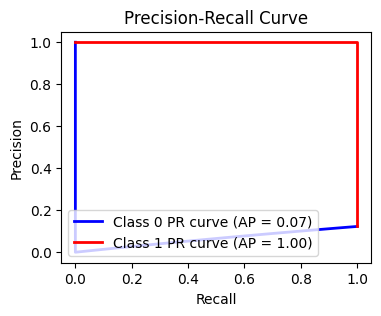

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics._plot.confusion_matrix import confusion_matrix

# PR 곡선 출력
pred_proba1_1 = svm.predict_proba(X_test)[:, 0]  # 첫 번째 열 확률
pred_proba2_1 = svm.predict_proba(X_test)[:, 1]  # 두 번째 열 확률

# 첫 번째 열 확률에 대한 PR 곡선 계산
PR_precision1_1, PR_recall1_1, _ = precision_recall_curve(y_test, pred_proba1_1)
average_precision1_1 = average_precision_score(y_test, pred_proba1_1)

# 두 번째 열 확률에 대한 PR 곡선 계산
PR_precision2_1, PR_recall2_1, _ = precision_recall_curve(y_test, pred_proba2_1)
average_precision2_1 = average_precision_score(y_test, pred_proba2_1)

# PR 곡선 그리기
plt.figure(figsize=(4, 3))
plt.plot(PR_recall1_1, PR_precision1_1, color='blue', lw=2, label=f'Class 0 PR curve (AP = {average_precision1_1:.2f})')
plt.plot(PR_recall2_1, PR_precision2_1, color='red', lw=2, label=f'Class 1 PR curve (AP = {average_precision2_1:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

- 결정 경계를 넘는 이상치가 있음에도 성능 지표가 1.0으로 나오지만 Feature1은 낮은 AP값을 보이며 PR곡선 아래 면적인 AUC-PR 또한 낮은 값을 보입니다.
- 이는 데이터 불균형으로 인해 성능이 정확하지 않다는 것을 의미합니다.
- 따라서 오버샘플링을 진행해 소수 클래스가 다수 클래스 개수에 맞춰보도록 하겠습니다.

# 5- Over sampling : resample

In [ ]:
from sklearn.utils import resample

# 소수 클래스와 다수 클래스로 분할
X_minority = X_train[y_train == 0]  # 소수 클래스 (클래스 0)
X_majority = X_train[y_train == 1]  # 다수 클래스 (클래스 1)

# 소수 클래스 샘플 수 계산
n_minority = len(X_minority)

# 소수 클래스 데이터를 다수 클래스와 같은 수로 복제
X_minority_resampled = resample(X_minority, replace=True, n_samples=len(X_majority), random_state=42)

# 복제된 소수 클래스 데이터와 다수 클래스 데이터를 합치기
X_train_resampled = np.vstack((X_minority_resampled, X_majority))
y_train_resampled = np.hstack((np.zeros(len(X_majority)), np.ones(len(X_majority))))


# 6- Hyperparameter tuning & cross validation

- 이어서, 교차검증과 하이퍼파라미터 튜닝을 동시에 실행하는 그리드 서치를 실행하도록 하겠습니다.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

# 학습 데이터를 훈련 세트와 검증 세트로 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train_resampled, y_train_resampled, test_size=0.2, random_state=42)

# SVM 모델 생성
svm_model = SVC(random_state=42, probability=True)

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='f1')

# 학습 데이터로 그리드 서치 수행
grid_search.fit(X_val, y_val)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params)

# 최적의 모델
best_model = grid_search.best_estimator_


# 교차 검증 결과 출력
# cv_results = grid_search.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print(f"평균 F1 스코어: {mean_score:.3f}, 하이퍼파라미터: {params}")

최적의 하이퍼파라미터: {'C': 1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}


# 7- Re-training with the optimal hyperparameters

정확도 : 1.0000, 정밀도 : 1.0000, 재현율 : 1.0000, F1 : 1.0000


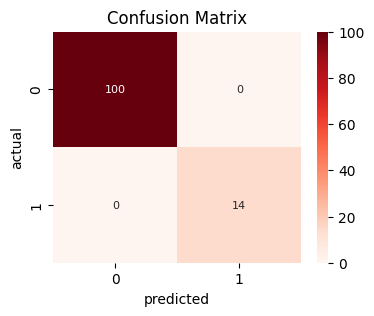

In [ ]:
# 최적의 모델로 학습
best_model.fit(X_train_resampled, y_train_resampled)

# 최적의 모델로 테스트 데이터 성능 평가
pred_best = best_model.predict(X_test)
get_clf_eval(y_test, pred_best)

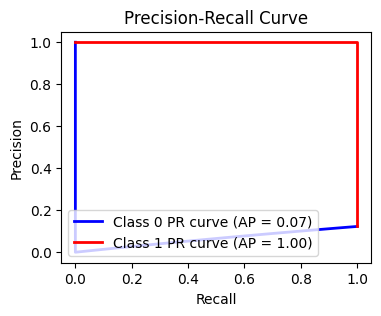

In [ ]:
# PR 곡선 출력
pred_proba1_2 = best_model.predict_proba(X_test)[:, 0]  # 클래스 0에 대한 확률
pred_proba2_2 = best_model.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률

# 첫 번째 열 확률에 대한 PR 곡선 계산
PR_precision1_2, PR_recall1_2, _ = precision_recall_curve(y_test, pred_proba1_2)
average_precision1_2 = average_precision_score(y_test, pred_proba1_2)

# 두 번째 열 확률에 대한 PR 곡선 계산
PR_precision2_2, PR_recall2_2, _ = precision_recall_curve(y_test, pred_proba2_2)
average_precision2_2 = average_precision_score(y_test, pred_proba2_2)

# PR 곡선 그리기
plt.figure(figsize=(4, 3))
plt.plot(PR_recall1_2, PR_precision1_2, color='blue', lw=2, label=f'Class 0 PR curve (AP = {average_precision1_2:.2f})')
plt.plot(PR_recall2_2, PR_precision2_2, color='red', lw=2, label=f'Class 1 PR curve (AP = {average_precision2_2:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

- 최적의 모델로 학습을 시켰지만 AP의 값와 PR곡선은 변함이 없었습니다.
- 두 피처 모두 AP 값이 향상될 것이라고 예상했지만 아니었습니다.
- 여전히 소수 클래스에 대한 예측 능력이 떨어집니다.

# 8- Over sampling : SMOTE

In [ ]:
from imblearn.over_sampling import SMOTE

# SMOTE 오버샘플링을 위한 객체 생성 및 1:1 비율 설정
smote = SMOTE(sampling_strategy= 1,random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
# 원본 데이터셋 시각화
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y, cmap='viridis', marker='o', s=50)
plt.title('Original Dataset')

# 오버 샘플링된 데이터셋 시각화
plt.subplot(1, 2, 2)
plt.scatter(X_train_smote[:, 0], X_train_smote[:, 1], c=y_resampled, cmap='viridis', marker='o', s=50)
plt.title('SMOTE Resampled Dataset')

plt.show()

In [ ]:
# 학습 데이터를 훈련 세트와 검증 세트로 분할
X_tr, X_val, y_tr, y_val = train_test_split(X_train_smote, y_train_smote, test_size=0.2, random_state=42)

# SVM 모델 생성
svm_model = SVC(random_state=42, probability=True)

# 튜닝할 하이퍼파라미터 그리드 설정
param_grid = {
    'C': [1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': [0.0001, 0.001, 0.01, 0.1, 1],
    'degree': [2, 3, 4]
}

# 그리드 서치 객체 생성
grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, cv=5, scoring='f1')

# 학습 데이터로 그리드 서치 수행
grid_search.fit(X_val, y_val)

# 최적의 하이퍼파라미터 출력
best_params_smote = grid_search.best_params_
print("최적의 하이퍼파라미터:", best_params_smote)

# 최적의 모델
best_model_smote = grid_search.best_estimator_


# 교차 검증 결과 출력
# cv_results = grid_search.cv_results_
# for mean_score, params in zip(cv_results["mean_test_score"], cv_results["params"]):
#     print(f"평균 F1 스코어: {mean_score:.3f}, 하이퍼파라미터: {params}")

최적의 하이퍼파라미터: {'C': 1, 'degree': 2, 'gamma': 0.0001, 'kernel': 'linear'}


정확도 : 1.0000, 정밀도 : 1.0000, 재현율 : 1.0000, F1 : 1.0000


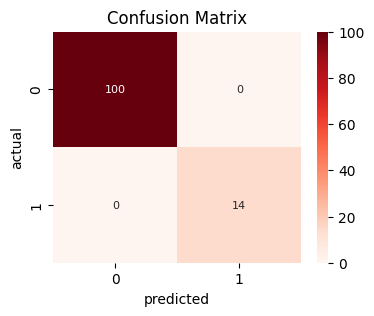

In [ ]:
# 최적의 모델로 학습
best_model_smote.fit(X_train_smote, y_train_smote)

# 최적의 모델로 테스트 데이터 성능 평가
pred_smote = best_model_smote.predict(X_test)
get_clf_eval(y_test, pred_smote)

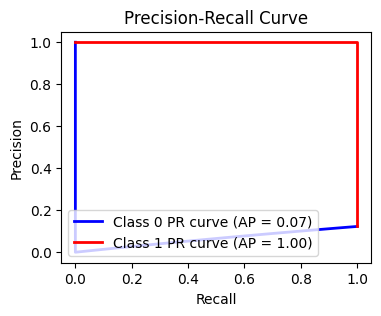

In [ ]:
# PR 곡선 출력
pred_proba1_3 = best_model_smote.predict_proba(X_test)[:, 0]  # 클래스 0에 대한 확률
pred_proba2_3 = best_model_smote.predict_proba(X_test)[:, 1]  # 클래스 1에 대한 확률

# 첫 번째 열 확률에 대한 PR 곡선 계산
PR_precision1_3, PR_recall1_3, _ = precision_recall_curve(y_test, pred_proba1_3)
average_precision1_3 = average_precision_score(y_test, pred_proba1_3)

# 두 번째 열 확률에 대한 PR 곡선 계산
PR_precision2_3, PR_recall2_3, _ = precision_recall_curve(y_test, pred_proba2_3)
average_precision2_3 = average_precision_score(y_test, pred_proba2_3)

# PR 곡선 그리기
plt.figure(figsize=(4, 3))
plt.plot(PR_recall1_3, PR_precision1_3, color='blue', lw=2, label=f'Class 0 PR curve (AP = {average_precision1_3:.2f})')
plt.plot(PR_recall2_3, PR_precision2_3, color='red', lw=2, label=f'Class 1 PR curve (AP = {average_precision2_3:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

- 예상과 달리, AP값은 향상되지 않았습니다.
- 그러한 이유는 하이퍼파라미터 튜닝을 할 때 C값의 범위를 1이상으로 두어 불균형 데이터에 대해 취약한 특성을 보이기 때문이라고 생각합니다.

# 9- Evaluation with real data

In [ ]:
# 분류해야 하는 실제 데이터 준비
X_real = []

for df in preprocessed_real:
  X_real.append(df.iloc[1, :].values)

X_real = np.array(X_real)

# 피처 스케일링
scaler = MinMaxScaler()
X_real_scaled = scaler.fit_transform(X_real)

# 실제 라벨 (ground truth) 준비
y_real = np.ones(len(X_real_scaled), dtype=int) * 1 # 모든 데이터의 라벨을 1로 초기화 (2단 데이터)

# 1번째, 2번째, 47번째, 48번째, 104번째 데이터의 라벨을 0로 설정 (1단 데이터)
y_real[[0, 1, 46, 47, 103]] = 0

print(f'1단 데이터의 개수 : {len(X_real[y_real==0])}')
print(f'2단 데이터의 개수 : {len(X_real[y_real==1])}')

1단 데이터의 개수 : 5
2단 데이터의 개수 : 99


In [ ]:
# 결정 트리 모델 학습
tree_model = DecisionTreeClassifier()
tree_model.fit(X_real_scaled, y_real)

# 중요한 피처 추출
feature_importance = tree_model.feature_importances_

# 중요도가 높은 상위 두 개의 피처 선택
top_features_indices_real = feature_importance.argsort()[-2:][::-1]
selected_features_real = X_real_scaled[:, top_features_indices_real]

top_features_indices_real

array([3, 2])

정확도 : 0.9904, 정밀도 : 1.0000, 재현율 : 0.9899, F1 : 0.9949


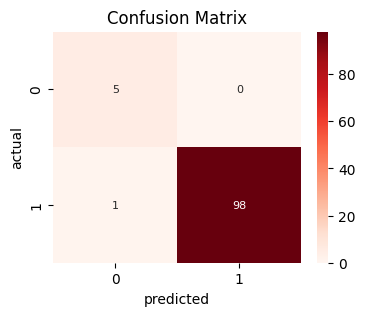

In [ ]:
# 최적의 모델로 실제 데이터 평가
pred_real = best_model_smote.predict(selected_features_real)
get_clf_eval(y_real, pred_real)

- 이 모델로 1단 데이터와 2단 데이터를 분류해보도록 하겠습니다.

#10- Detect & Count

In [ ]:
rope1_count = 0
rope2_count = 0

for i, pred in enumerate(pred_real):
    if pred == 0:
        result = "1단 줄넘기 데이터"
        rope1_count += 1
    else:
        result = "2단 줄넘기 데이터"
        rope2_count += 1
    print(f"실제 데이터 {i+1}:", result)

print("1단 줄넘기 데이터의 개수:", rope1_count)
print("2단 줄넘기 데이터의 개수:", round(rope2_count/2))

- 이러한 결과를 아래에서 분석해보았습니다.

# 11- Analysis using KNN

- 실제 데이터를 KNN모델로 학습 시키고 시각화를 해보았습니다.

Outlier Indices for 3 neighbors: [48]
Outlier Indices for 5 neighbors: [48]
Outlier Indices for 7 neighbors: [  0  46 103]


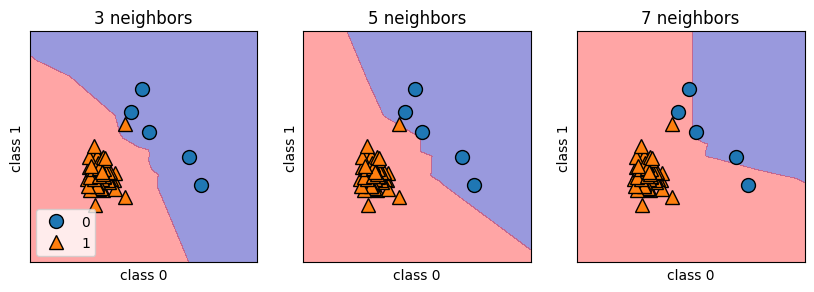

In [ ]:
import mglearn
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier

fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([3, 5, 7], axes):
    knn = KNeighborsClassifier(n_neighbors=n_neighbors).fit(selected_features_real, y_real)
    mglearn.plots.plot_2d_separator(knn, selected_features_real, fill=True, eps=0.5, ax=ax, alpha=.4)
    mglearn.discrete_scatter(selected_features_real[:, 0], selected_features_real[:, 1], y_real, ax=ax)
    ax.set_title("{} neighbors".format(n_neighbors))
    ax.set_xlabel("class 0")
    ax.set_ylabel("class 1")

    # 경계를 넘는 데이터의 인덱스 찾기
    y_pred = knn.predict(selected_features_real)
    outlier_indices = np.where(y_pred != y_real)[0]

    # 이상치의 인덱스 출력
    print("Outlier Indices for {} neighbors: {}".format(n_neighbors, outlier_indices))

axes[0].legend(loc=3)
plt.show()

- 시각화한 결과를 보면 49번째 실제 데이터가 2단과 매우 가까이 있습니다.
- 이를 통해 49번째 실제 데이터는 다른 2단 데이터와 다르게 1단 데이터의 패턴과 매우 유사해 1단 데이터로 분류했음을 알 수 있습니다.